In [1]:
import mbuild
import foyer
import mosdef_cassandra as mc
import unyt as u
import numpy as np
import os
from mosdef_cassandra.utils.tempdir import temporary_cd
from mosdef_cassandra.analysis import ThermoProps
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
temperature = 308.0 * u.K

/home/emarinri/miniconda3/envs/cassandra-tutorial/lib/python3.9/site-packages/mbuild/conversion.py:1760: UserWarning: No element attribute associated with '<_CH4 pos=([0. 0. 0.]), 0 bonds, id: 140083048329072>'; and no matching elements found based upon the compound name. Setting atomic number to zero.
  warn(warn_msg)
/home/emarinri/miniconda3/envs/cassandra-tutorial/lib/python3.9/site-packages/mbuild/compound.py:400: UserWarning: Some particle of <_CH4 pos=([0. 0. 0.]), 0 bonds, id: 140083048329072> does not have a charge.They will not be accounted for during this calculation.
  warn(
/home/emarinri/miniconda3/envs/cassandra-tutorial/lib/python3.9/site-packages/parmed/openmm/topsystem.py:240: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  warnings.warn('Adding what seems to be Urey-Bradley terms before ' # pragma: no cover
/home/emarinri/miniconda3/envs/cassandra-tutorial/li

Using the following executables for Cassandra:
Python: /home/emarinri/miniconda3/envs/cassandra-tutorial/bin/python
library_setup: /home/emarinri/miniconda3/envs/cassandra-tutorial/bin/library_setup.py
Cassandra: /home/emarinri/miniconda3/envs/cassandra-tutorial/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/emarinri/miniconda3/envs/cassandra-tutorial/bin/python
library_setup: /home/emarinri/miniconda3/envs/cassandra-tutorial/bin/library_setup.py
Cassandra: /home/emarinri/miniconda3/envs/cassandra-tutorial/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/emarinri/miniconda3/envs/cassandra-tutorial/bin/python
library_setup: /home/emarinri/miniconda3/envs/cassandra-tutorial/bin/library_setup.py
Cassandra: /home/emarinri/miniconda3/envs/cassandra-tutorial/bin/cassandra.exe
Generating fragment libraries...
Running Cassandr

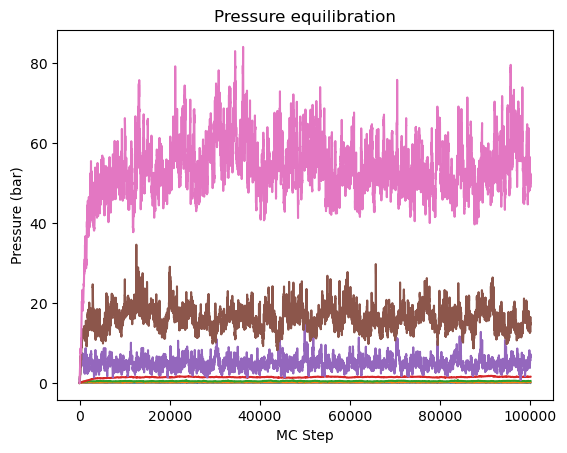

In [3]:
methane = mbuild.Compound(name='_CH4')

# Load force field
trappe = foyer.forcefields.load_TRAPPE_UA()

# Use foyer to apply force field
methane_typed = trappe.apply(methane)

custom_args = {
    "charge_style" : "none",
    "vdw_cutoff" : 14.0 * u.angstrom,
    "prop_freq" : 10,
}


mus_adsorbate = np.arange(-46, -25, 3) * u.kJ/u.mol

for mu_adsorbate in mus_adsorbate:
   dirname = f'pure_mu_{mu_adsorbate:.1f}'.replace(" ", "_").replace("/", "-")
   if not os.path.isdir(dirname):
       os.mkdir(dirname)
   else:
       pass
   with temporary_cd(dirname):
       species_list = [methane_typed]
       if mu_adsorbate < -34:
           boxl = 20. # nm
       else:
           boxl = 5. # nm
       box_list = [mbuild.Box([boxl,boxl,boxl])]
       system = mc.System(box_list, species_list)
       moveset = mc.MoveSet('gcmc', species_list)

       mc.run(
           system=system,
           moveset=moveset,
           run_type="equil",
           run_length=100000,
           temperature=temperature,
           chemical_potentials = [mu_adsorbate],
           **custom_args
       )

pressures = []
for mu_adsorbate in mus_adsorbate:
    dirname = f'pure_mu_{mu_adsorbate:.1f}'.replace(" ", "_").replace("/", "-")
    thermo = ThermoProps(dirname + "/gcmc.out.prp")
    pressures.append(np.mean(thermo.prop("Pressure", start=30000)))
    plt.plot(thermo.prop("MC_STEP"), thermo.prop("Pressure"))

plt.title("Pressure equilibration")
plt.xlabel("MC Step")
plt.ylabel("Pressure (bar)")
plt.show()

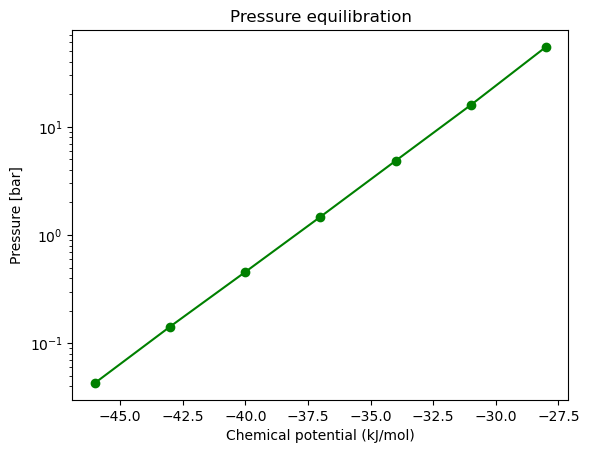

We will run at mu = -45.15 kJ/mol to simulate    0.06000 bar
We will run at mu = -41.85 kJ/mol to simulate    0.22100 bar
We will run at mu = -39.83 kJ/mol to simulate    0.49180 bar
We will run at mu = -37.53 kJ/mol to simulate    1.21800 bar
We will run at mu = -35.12 kJ/mol to simulate    3.16800 bar
We will run at mu = -32.65 kJ/mol to simulate    8.39700 bar
We will run at mu = -30.17 kJ/mol to simulate   22.43000 bar
We will run at mu = -27.68 kJ/mol to simulate   60.00000 bar


In [4]:
plt.title("Pressure equilibration")
plt.xlabel("MC Step")
plt.ylabel("Pressure (bar)")
plt.plot(mus_adsorbate, pressures, 'go-')
plt.xlabel("Chemical potential (kJ/mol)")
plt.ylabel("Pressure [bar]")
plt.yscale('log')
slope, intercept, r_value, p_value, stderr = linregress(np.log(pressures).flatten(),y=mus_adsorbate.flatten())
plt.show()

pressures = [
    6000   ,
    22100  ,
    49180  ,
    121800 ,
    316800 ,
    839700 ,
    2243000,
    6000000
] * u.Pa

mus = (slope * np.log(pressures.in_units(u.bar)) + intercept) * u.kJ/u.mol
for (mu, pressure) in zip(mus, pressures):
    print(f"We will run at mu = {mu:0.2f} to simulate {pressure.in_units(u.bar):10.5f}")
